In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from net import SpatialEncoder
from utils import *
import tqdm
import gc
from pathlib import Path
import numpy as np

In [2]:
model = SpatialEncoder()
optimizer = optim.Adam(model.parameters())

In [3]:
checkpoint = torch.load(r'C:\Users\cdami\Documents\Python Scripts\Spatiotemporal-Autoencoder-Anomaly-Detection\checkpoints\1_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_test = checkpoint['loss_test']
loss_train = checkpoint['loss_train']

In [4]:
train_path = Path('Avenue Dataset/training_vol')
test_path = Path('Avenue Dataset/testing_vol')

In [5]:
set_test = FileDataset(train_path, test_path, train=False)
test_data_loader = torch.utils.data.DataLoader(set_test, batch_size=1, shuffle=True)

In [6]:
device = torch.device('cuda')
# model = model.to(device)
model.eval()

SpatialEncoder(
  (conv1): Conv3d(1, 128, kernel_size=(1, 11, 11), stride=(1, 4, 4))
  (conv2): Conv3d(128, 64, kernel_size=(1, 5, 5), stride=(1, 2, 2))
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (convt1): ConvTranspose3d(64, 128, kernel_size=(1, 5, 5), stride=(1, 2, 2))
  (convt2): ConvTranspose3d(128, 1, kernel_size=(1, 11, 11), stride=(1, 4, 4))
)

In [7]:
first_data = next(iter(test_data_loader))

Generating strides for Avenue Dataset\testing_vol\vol20.mat
Generating strides for Avenue Dataset\testing_vol\vol20.mat
Generating strides for Avenue Dataset\testing_vol\vol20.mat


In [8]:
first_data.shape

torch.Size([1, 483, 1, 10, 227, 227])

In [9]:
anomaly_set = AnomalyDataset(first_data[0])

In [10]:
test_loader = torch.utils.data.DataLoader(anomaly_set, batch_size=12, shuffle=False)

In [11]:
device_cpu = torch.device('cpu')

In [12]:
outputs = []
model.eval()
for x in tqdm.tqdm(test_loader):
    # x = x.to(device)
    out = model(x)
    out = out.detach().numpy()
    print(type(out))
    # out = model.to(device_cpu)
    outputs.append(out)

  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 33/33 [01:35<00:00,  2.88s/it]<class 'numpy.ndarray'>



In [13]:
outputs = np.asarray(outputs)

C:\Users\cdami\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
outputs = outputs.squeeze()

In [22]:
outputs = list(outputs)

In [23]:
outputs = [torch.Tensor(x) for x in outputs]

In [28]:
outputs = torch.cat(outputs)

In [30]:
outputs.shape

torch.Size([386, 1, 10, 227, 227])

In [46]:
outputs.shape

(96, 10, 227, 227)

In [31]:
inputs = []
for x in tqdm.tqdm(test_loader):
    inputs.append(x)

100%|██████████| 33/33 [00:00<00:00, 170.16it/s]


In [34]:
inputs = torch.cat(inputs)

In [35]:
inputs = inputs.squeeze()
outputs = outputs.squeeze()

In [36]:
inputs.shape, outputs.shape

(torch.Size([386, 10, 227, 227]), torch.Size([386, 10, 227, 227]))

In [42]:
def calculate_abnormality_score(input, output):
    input = torch.flatten(input)
    output = torch.flatten(output)
    return torch.sqrt(torch.sum(torch.square(input - output)))

In [43]:
abnormality_scores = []
for i in tqdm.tqdm(range(len(inputs))):
    abnormality_scores.append(calculate_regularity_score(inputs[i], outputs[i]))

abnormality_scores = np.array(abnormality_scores)

100%|██████████| 386/386 [00:00<00:00, 632.10it/s]


In [44]:
minimum, maximum = min(abnormality_scores), max(abnormality_scores)
abnormality_scores = (abnormality_scores - minimum) / maximum


In [45]:
regularity_scores = 1 - abnormality_scores

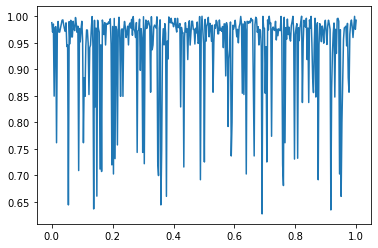

In [46]:
plt.plot(np.linspace(0,1, len(regularity_scores)), regularity_scores)